In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [132]:
import os
import wfdb
from scipy.interpolate import interp1d

signals = np.empty((64, 90000, 2))
labels = []
ts_files = []
input_path = f'E:/database/gait-in-neurodegenerative-disease-database-1.0.0'
for file_name in sorted(os.listdir(f'{input_path}')):
    if not file_name.endswith('hea'):
        continue
    label = ''.join(filter(lambda x: x.isalpha(), file_name[:-4]))
    file_name = f'{input_path}/{file_name[:-4]}'
    sig, info = wfdb.rdsamp(file_name)

    t = np.arange(len(sig))
    for j in range(2):
        mask_na = np.isnan(sig[..., j])
        f = interp1d(t[~mask_na], sig[~mask_na, j], fill_value='extrapolate')
        sig[mask_na, j] = f(t[mask_na])
    signals[len(labels)] = sig; labels.append( label )
    assert info['fs'] == 300
    assert info['sig_len'] == 90000

    ts_file = pd.read_csv(
        file_name + '.ts',
        delimiter='\t',
        names=[
            'Elapsed Time (sec)',
            'Left Stride Interval (sec)', 'Right Stride Interval (sec)', 'Left Swing Interval (sec)', 'Right Swing Interval (sec)',
            'Left Swing Interval (% of stride)', 'Right Swing Interval (% of stride)', 
            'Left Stance Interval (sec)', 'Right Stance Interval (sec)', 
            'Left Stance Interval (% of stride)', 'Right Stance Interval (% of stride)',
            'Double Support Interval (sec)', 'Double Support Interval (% of stride)'
        ]
    )
    ts_files.append(ts_file)
    
labels = np.array(labels)

In [89]:
df_tabular = pd.read_csv(
    f'{input_path}/subject-description.txt', 
    delimiter='\t',
    na_values='MISSING'
)
df_tabular['gender'] = (df_tabular['gender'] == 'm').astype(int)
tabular_data_preimpute = df_tabular.iloc[:, 2:].values

from sklearn.impute import SimpleImputer

tabular_data = SimpleImputer().fit_transform(features_tabular_preimpute)

In [91]:
seg_len = 450

segs = []
seg_labels = []
seg_indivs = []
mask_nonstart = []
for i in range(signals.shape[0]):
    signal = signals[i]
    for j in range(0, signals.shape[1], seg_len):
        segs.append(signal[j:j+seg_len])
        seg_labels.append( labels[i] )
        seg_indivs.append(i)
        mask_nonstart.append(seg_len*j >= 300*20)
segs = np.array(segs); seg_labels = np.array(seg_labels); seg_indivs = np.array(seg_indivs)
mask_nonstart = np.array(mask_nonstart)

In [160]:
from scipy.interpolate import interp1d

features_ts = np.empty((segs.shape[0], 12))
for i in range(signals.shape[0]):
    ts_file = ts_files[i]
    x, y = ts_file['Elapsed Time (sec)']*300, ts_file.iloc[:, 1:].values
    f = interp1d(
        x, y,
        axis=0, bounds_error=False, fill_value=(y[0], y[-1]),
    )
    features_ts[seg_indivs==i] = f(np.arange(0, signals.shape[1], seg_len) + 0.5*seg_len)

In [4]:
from tools import Embedder, Weighting, SineFilter, calculate_weighting_vectors
import itertools

embedder = Embedder(lag=24, reduce=0, dim_raw=2, channel_last=True)
x = embedder.transform(segs)
w = calculate_weighting_vectors(10*x)[..., np.newaxis]

In [166]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# sine_filter = SineFilter(dim=x.shape[-1], n_filters=32, scale=1e1, random_state=42)
# sine_0d = sine_filter.apply(x, w)

features = np.concatenate([
    sine_0d,
    # sine_unif,
    tabular_data[seg_indivs],
    features_ts
], axis=-1)

subcls = ['als', 'control']
mask_subcls = np.isin(seg_labels, subcls)

y_true = seg_labels.copy()
y_pred = y_true.copy()

rng = np.random.default_rng(42)
n_fold = 5
fold_assignment = rng.integers(0, n_fold, size=y_true.shape)
for test_indiv in np.unique(seg_indivs[np.isin(seg_labels, subcls)]):
    # indivs_test = indivs_shuffled[(len(labels)*fold_no)//n_fold:(len(labels)*(fold_no+1))//n_fold]
    # mask_test = np.isin(seg_indivs, indivs_test)

    mask_train = (seg_indivs != test_indiv) & mask_subcls & mask_nonstart
    mask_test = (seg_indivs == test_indiv) & mask_subcls & mask_nonstart
    # mask_test = fold_assignment == fold_no
    # mask_train = ~mask_test

    model = make_pipeline(
        # PCA(
        #     n_components=5,
        #     whiten=True,
        #     random_state=42
        # ),
        # KNeighborsClassifier(
        #     n_neighbors=5,
        # )
        LGBMClassifier(
            random_state=42
        )
    )
    model.fit(features[mask_train], seg_labels[mask_train])
    y_pred[mask_test] = model.predict(features[mask_test])
    print(test_indiv, f'{1e2*accuracy_score(y_true[mask_test], y_pred[mask_test]):.2f}')

print()
print(accuracy_score(y_true[mask_subcls & mask_nonstart], y_pred[mask_subcls & mask_nonstart])*1e2)
print(confusion_matrix(y_true[mask_subcls & mask_nonstart], y_pred[mask_subcls & mask_nonstart]))

0 100.00
1 96.98
2 100.00
3 100.00
4 100.00
5 0.00
6 100.00
7 100.00
8 100.00
9 100.00
10 100.00
11 95.98
12 100.00
13 9.05
14 100.00
15 0.00
16 100.00
17 100.00
18 100.00
19 100.00
20 100.00
21 100.00
22 100.00
23 100.00
24 100.00
25 100.00
26 100.00
27 100.00
28 100.00

89.72448449142263
[[2374  213]
 [ 380 2804]]


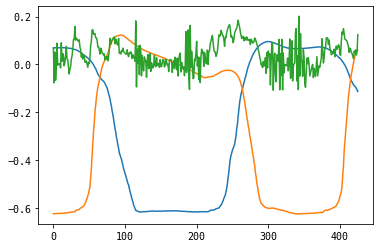

In [115]:
plt.plot( x[mask_nonstart & mask_subcls][1200, :, ::2])
plt.plot( w[mask_nonstart & mask_subcls][1200, :, 0] )

In [ ]:
# plt.plot(x[(y_true==labels[0]) & (y_pred==labels[1])][18])
plt.plot(*x[(y_true==labels[0]) & (y_pred==labels[1])][22, :, :2].T)
plt.plot(*x[(y_true==labels[0]) & (y_pred==labels[1])][22, :, 2:].T)

In [128]:
from umap import UMAP

w_alter = calculate_weighting_vectors(x)[..., np.newaxis]
sine_alter = sine_filter.apply(x, w_alter)
reducer = UMAP(random_state=42)
reduced = reducer.fit_transform(sine_alter[mask_nonstart])

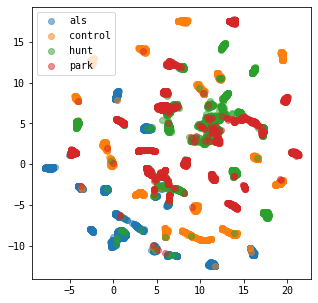

In [129]:
plt.figure(figsize=(5, 5))
for num, label in enumerate(np.unique(labels)):
    plt.scatter(*reduced[seg_labels[mask_nonstart]==label].T, color=f'C{num}', alpha=0.5, label=label)
plt.legend()
plt.show(); plt.close()

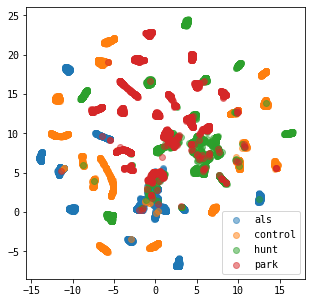

In [130]:
reduced = reducer.fit_transform(sine_0d[mask_nonstart])
plt.figure(figsize=(5, 5))
for num, label in enumerate(np.unique(labels)):
    plt.scatter(*reduced[seg_labels[mask_nonstart]==label].T, color=f'C{num}', alpha=0.5, label=label)
plt.legend()
plt.show(); plt.close()

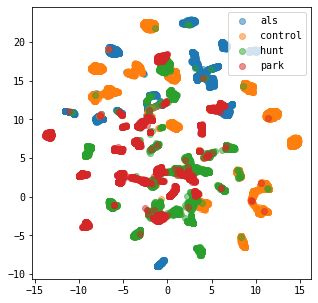

In [131]:
sine_unif = sine_filter.apply(x, np.ones_like(w))
reduced = reducer.fit_transform(sine_unif[mask_nonstart])
plt.figure(figsize=(5, 5))
for num, label in enumerate(np.unique(labels)):
    plt.scatter(*reduced[seg_labels[mask_nonstart]==label].T, color=f'C{num}', alpha=0.5, label=label)
plt.legend()
plt.show(); plt.close()

In [ ]:
for i in range(signals.shape[0]):
    plt.figure(figsize=(24, 1))
    plt.plot(signals[i, ::3])
    for j in range(100):
        plt.gca().axvline(x=j*300, ymin=0, ymax=1, linestyle='--', linewidth=1, color='#888888')
    for j in range(20):
        plt.gca().axvline(x=j*5*300, ymin=0, ymax=1, linewidth=1, color='#000000')
    for j in range(10):
        plt.gca().axvline(x=j*2*5*300, ymin=0, ymax=1, linewidth=2, color='#000000')
    # plt.title(np.sum(np.isnan(signals[i])))
    plt.title(i)
    plt.xlim(0, 30000)
    plt.show();plt.close()

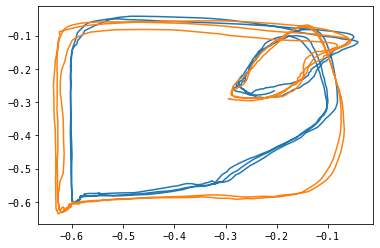

In [31]:
plt.plot(signals[0, 6000:7000], signals[0, 6024:7024])

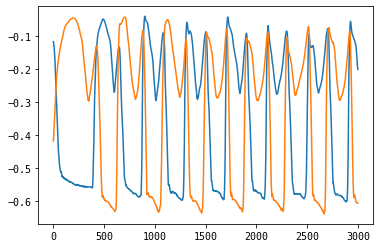

In [11]:
plt.plot(signals[0, 3000:6000])